In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics

In [12]:
#TF.keras.dataset的api已經整理很乾淨。因此，若使用的都可以直接call api，就可以下載dataset到local做使用。
(x,y),(x_test,y_test) = datasets.fashion_mnist.load_data()

In [3]:
print(x.shape,y.shape) 

(60000, 28, 28) (60000,)


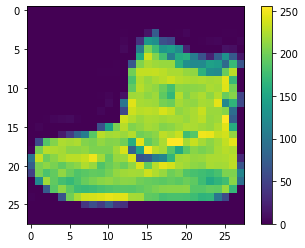

In [ ]:
plt.figure()
plt.imshow(x[0])
plt.colorbar()
plt.grid(False)

In [4]:
# Transformation

def feature_scale(x,y):
  x = tf.cast(x,dtype=tf.float32)/255.
  y = tf.cast(y,dtype=tf.int32)
  return x,y

In [24]:
x

<tf.Tensor: shape=(16, 784), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [25]:
y

<tf.Tensor: shape=(16,), dtype=int32, numpy=array([7, 6, 8, 9, 5, 2, 4, 8, 9, 8, 5, 7, 1, 7, 4, 7], dtype=int32)>

In [6]:
# 讀取檔案
# 以map來說，就是將function套用到每一個dataset裡面的element。
# shuffle的話就是打散整個dataset，最後在設定你一個batch要有多少筆資料。

data = tf.data.Dataset.from_tensor_slices((x,y)) 
data = data.map(feature_scale).shuffle(10000).batch(128)

data_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
data_test = data_test.map(feature_scale).shuffle(10000).batch(128)

In [7]:
#建立好Dataset之後，就是將資料迭代化，這是tf.data api的特色。
#建立Dataset -> 資料迭代化 -> 放進Model
data_iter = iter(data)

In [8]:
samples = next(data_iter)
print(samples[0].shape,samples[1].shape)

(128, 28, 28) (128,)


In [9]:
#定義模型:

model = Sequential([
    layers.Dense(256,activation=tf.nn.relu),
    layers.Dense(128,activation=tf.nn.relu),
    layers.Dense(64,activation=tf.nn.relu),
    layers.Dense(32,activation=tf.nn.relu),
    layers.Dense(10,activation=tf.nn.relu)
])

In [10]:
model.build(input_shape=[None,28*28])

model.summary()
optimizer = optimizers.Adam()  #定義要使用的優化器

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  200960    
_________________________________________________________________
dense_1 (Dense)              multiple                  32896     
_________________________________________________________________
dense_2 (Dense)              multiple                  8256      
_________________________________________________________________
dense_3 (Dense)              multiple                  2080      
_________________________________________________________________
dense_4 (Dense)              multiple                  330       
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Training

for i in range(10):
  for step,(x,y) in enumerate(data):
    
    x = tf.reshape(x,[-1,28*28])
    
    with tf.GradientTape() as tape: #使用TF 2.0主要使用自動計算gradient的方法
      logits = model(x)
      y_one_hot = tf.one_hot(y,depth=10)
      loss = tf.losses.categorical_crossentropy(y_one_hot,logits,from_logits=True)
      loss = tf.reduce_mean(loss)

    #計算出loss後，會使用tape.gradient將loss傳入計算gradient  
    grads = tape.gradient(loss,model.trainable_variables)
     #最後使用前面所設的optimizer來更新weight
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
    if step %100==0:
      print(i,step,'loss:',float(loss))

0 0 loss: 2.2838573455810547
0 100 loss: 0.9665687084197998
0 200 loss: 0.5424937009811401
0 300 loss: 0.6634923219680786
0 400 loss: 0.6186873912811279
1 0 loss: 0.7764382362365723
1 100 loss: 0.6673731207847595
1 200 loss: 0.4250473380088806
1 300 loss: 0.6130275726318359
1 400 loss: 0.7520390152931213
2 0 loss: 0.48721635341644287
2 100 loss: 0.5568146705627441
2 200 loss: 0.594567060470581
2 300 loss: 0.5937033891677856
2 400 loss: 0.5452064275741577
3 0 loss: 0.6516647934913635
3 100 loss: 0.4794962704181671
3 200 loss: 0.4636414647102356
3 300 loss: 0.4504478871822357
3 400 loss: 0.5713880062103271
4 0 loss: 0.49743038415908813
4 100 loss: 0.5244797468185425
4 200 loss: 0.4908595085144043
4 300 loss: 0.3886023759841919
4 400 loss: 0.47019365429878235
5 0 loss: 0.4019298553466797
5 100 loss: 0.38109517097473145
5 200 loss: 0.5297020673751831
5 300 loss: 0.42225149273872375
5 400 loss: 0.35670867562294006
6 0 loss: 0.6256334781646729
6 100 loss: 0.48903006315231323
6 200 loss: 0.43

In [28]:
# Testing

total_loss = 0
total_num=0
for x,y in data_test:
  
  x = tf.reshape(x,[-1,28*28])
  
  gd = model(x)
  prob = tf.nn.softmax(gd,axis=1) #輸出層損失函數
  pred = tf.argmax(prob,axis=1)   #取預測多類別中最高的預測值
  
  pred = tf.cast(pred,dtype=tf.int32) #分入類別
  correct = tf.equal(pred,y)  #針對預測結果與真實是否相同做出比較
  
  result = tf.reduce_sum(tf.cast(correct,dtype=tf.int32))
  
  total_loss += int(result)
  total_num += x.shape[0]
  
acc = total_loss/total_num

In [ ]:
prob

In [16]:
pred

<tf.Tensor: shape=(16,), dtype=int32, numpy=array([7, 6, 8, 9, 5, 2, 0, 8, 9, 8, 5, 7, 1, 7, 0, 7], dtype=int32)>

In [17]:
correct 
# 14個True和2個False

<tf.Tensor: shape=(16,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True])>

In [20]:
result 

<tf.Tensor: shape=(), dtype=int32, numpy=14>

In [21]:
int(result)

14

In [ ]:
total_loss

In [ ]:
total_num

In [29]:
acc

0.8168